In [23]:
input_3sat_instance = """
c example DIMACS-CNF 3-SAT
p cnf 3 3
1 2 -3 0
-1 -2 -3 0
-1 2 3 0
"""

In [24]:
import tempfile
from qiskit.circuit.library.phase_oracle import PhaseOracle

fp = tempfile.NamedTemporaryFile(mode="w+t", delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)


                     
q_0: ─■───────────■──
      │ ┌───┐     │  
q_1: ─■─┤ Z ├─o───o──
      │ ├───┤ │ ┌───┐
q_2: ─■─┤ X ├─■─┤ X ├
        └───┘   └───┘


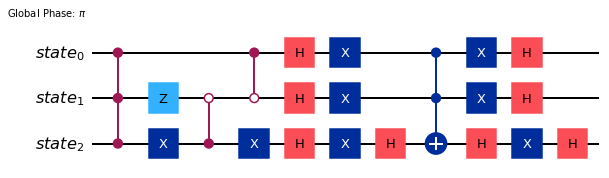

In [25]:
from qiskit_algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

print(oracle)
problem.grover_operator.decompose().draw(output="mpl")



In [26]:
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler(), iterations=2)
result = grover.amplify(problem)
print("Result type:", type(result))
print()
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)

iterations = Grover.optimal_num_iterations(num_solutions=5, num_qubits=8)
iterations


Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 000


C:\Users\admin\AppData\Local\Temp/ipykernel_3544/3911943913.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler(), iterations=2)


5

[{'000': 0.1953124999999996, '001': 0.0078125, '010': 0.1953124999999996, '011': 0.1953124999999995, '100': 0.0078125, '101': 0.1953124999999995, '110': 0.1953124999999996, '111': 0.0078125}]


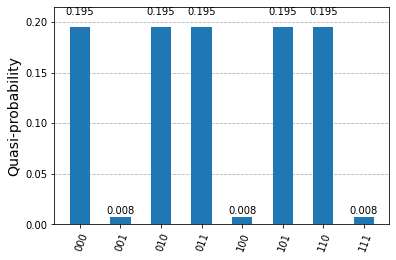

In [27]:
from qiskit.visualization import plot_histogram

if result is not None:
    print(result.circuit_results)
    display(plot_histogram(result.circuit_results[0]))

if result is None:
    print(result)

In [28]:
import random as rnd

def parse_dimacs(file_name):
    clauses = []
    num_vars = 0
    with open(file_name, "r") as file:
        for line in file:
            if line.startswith("p"):
                _, _, num_vars, _ = line.split()
                num_vars = int(num_vars)
            elif not line.startswith("c") and line.strip():
                clause = [int(lit) for lit in line.split() if lit != '0']
                clauses.append(clause)
    return int(num_vars), clauses

num_vars, clauses = parse_dimacs(file_name)

In [29]:
def test(binvec, clause):
    
    for lit in clause:
        if (lit > 0 and binvec[abs(lit) - 1]) or (lit < 0 and not binvec[abs(lit) - 1]):
            return True
    return False

def check(binvec, clauses):
    return [test(binvec, clause) for clause in clauses]


In [30]:
def schoening_iter(binvec, clauses):
    n = len(binvec)
    for __ in range(3 * n):
        state = check(binvec, clauses)
        if all(state):  # If all clauses are satisfied, return the solution
            return binvec
        for i, satisfied in enumerate(state):
            if not satisfied:
                # Flip a random variable in the clause
                clause = clauses[i]
                while not test(binvec, clause):
                    idx = rnd.choice([abs(lit) - 1 for lit in clause])
                    binvec[idx] = not binvec[idx]
                break
    return binvec

In [31]:
solution_found = False
for _ in range(int((4 / 3) ** num_vars)):
    binvec = [rnd.choice([False, True]) for _ in range(num_vars)]
    binvec = schoening_iter(binvec, clauses)
    if all(check(binvec, clauses)):
        solution_found = True
        break

In [32]:
if solution_found:
    print("SATISFIABLE")
    print("Solution:", [int(val) for val in binvec])
else:
    print("UNSATISFIABLE")


SATISFIABLE
Solution: [1, 0, 1]
